In [1]:
import sklearn
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
from pathlib import Path
import xgboost as xgb
import math
from sklearn.metrics import mean_squared_error
import talib as tb
from tqdm import tqdm_notebook
import pandas_ta as ta
from ipywidgets import FloatProgress
# from .autonotebook import tqdm as notebook_tqdm



%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

/Users/josephkiragu/opt/anaconda3/envs/venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Loading the data

In [2]:
DATA_PATH = 'ford.csv'
if not Path(DATA_PATH).is_file(): 
	ford_stock = yf.download('F',
				start = '2000-01-01',
				end = '2022-08-01',
				progress = False)
	ford_stock.to_csv(DATA_PATH)
else :
	ford_stock = pd.read_csv("ford.csv")

In [3]:
ford_stock[['Open']].values

array([[28.98847389],
       [28.47327614],
       [28.02677155],
       ...,
       [12.75      ],
       [13.93999958],
       [14.10999966]])

In [4]:
ford_stock.head(3)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,28.988474,29.228899,28.645008,28.782394,14.585280,4056814
1,2000-01-04,28.473276,28.713701,27.648958,27.820692,14.097949,7322428
2,2000-01-05,28.026772,28.301542,27.889385,27.923731,14.150164,5038354


## Feature Engineering

### Adding technical indicators to create more features

In [5]:
def technical_indicators_df(ford_stock):
    c = ford_stock['Close'].values
    h = ford_stock['High'].values
    l = ford_stock['Low'].values
    v = ford_stock['Volume'].astype(float).values


    ford_stock['MA5'] = tb.MA(c, timeperiod=5)
    ford_stock['MA10'] = tb.MA(c, timeperiod=10)
    ford_stock['MA20'] = tb.MA(c, timeperiod=20)
    # ford_stock['MA60'] = tb.MA(c, timeperiod=30)
    ford_stock['MA5'] = tb.MA(v, timeperiod=5)
    ford_stock['MA10'] = tb.MA(v, timeperiod=10)
    ford_stock['MA20'] = tb.MA(v, timeperiod=20)
    ford_stock['ADX'] = tb.ADX(h, l, c, timeperiod=14)
    ford_stock['ADXR'] = tb.ADXR(h, l, c, timeperiod=14)
    ford_stock['MACD'] = tb.MACD(c, fastperiod=12, slowperiod=26, signalperiod=9)[0]
    ford_stock['RSI'] = tb.RSI(c, timeperiod=14)
    ford_stock['BBANDS_U'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[0]
    ford_stock['BBANDS_M'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1]
    ford_stock['BBANDS_L'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[2]
    ford_stock['AD'] = tb.AD(h, l, c, v)
    ford_stock['ATR'] = tb.ATR(h, l, c, timeperiod=14)
    ford_stock['HT_DC'] = tb.HT_DCPERIOD(c)
     
    return ford_stock

In [6]:
ford_stock_indicators = technical_indicators_df(ford_stock)

In [7]:
ford_stock_indicators.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA5',
       'MA10', 'MA20', 'ADX', 'ADXR', 'MACD', 'RSI', 'BBANDS_U', 'BBANDS_M',
       'BBANDS_L', 'AD', 'ATR', 'HT_DC'],
      dtype='object')

### Shifting all features apart from closing price one day behind in order to predict the next day

In [8]:
# Add a column 'order_day' to indicate the order of the rows by date
ford_stock_indicators['order_day'] = [x for x in list(range(len(ford_stock_indicators)))]
print(ford_stock_indicators.head())

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['Open','High', 'Low', 'Close','Adj Close','Volume', 'MA5',
       'MA10', 'MA20', 'ADX', 'ADXR', 'MACD', 'RSI', 'BBANDS_U', 'BBANDS_M',
       'BBANDS_L', 'AD', 'ATR', 'HT_DC']
lag_cols

         Date       Open       High        Low      Close  Adj Close   Volume  \
0  2000-01-03  28.988474  29.228899  28.645008  28.782394  14.585280  4056814   
1  2000-01-04  28.473276  28.713701  27.648958  27.820692  14.097949  7322428   
2  2000-01-05  28.026772  28.301542  27.889385  27.923731  14.150164  5038354   
3  2000-01-06  28.026772  28.473276  27.683306  27.958078  14.167570  4545037   
4  2000-01-07  28.851088  30.224949  28.645008  30.018869  15.211860  9266037   

         MA5  MA10  MA20  ...  ADXR  MACD  RSI  BBANDS_U   BBANDS_M  \
0        NaN   NaN   NaN  ...   NaN   NaN  NaN       NaN        NaN   
1        NaN   NaN   NaN  ...   NaN   NaN  NaN       NaN        NaN   
2        NaN   NaN   NaN  ...   NaN   NaN  NaN       NaN        NaN   
3        NaN   NaN   NaN  ...   NaN   NaN  NaN       NaN        NaN   
4  6045734.0   NaN   NaN  ...   NaN   NaN  NaN  30.16783  28.500753   

    BBANDS_L            AD  ATR  HT_DC  order_day  
0        NaN -2.147722e+06  NaN   

['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'MA5',
 'MA10',
 'MA20',
 'ADX',
 'ADXR',
 'MACD',
 'RSI',
 'BBANDS_U',
 'BBANDS_M',
 'BBANDS_L',
 'AD',
 'ATR',
 'HT_DC']

In [9]:
shift_range = [x+1 for x in range(1)]

for shift in tqdm_notebook(shift_range):
    train_shift = ford_stock_indicators[merging_keys + lag_cols].copy()
    
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(ford_stock_indicators, train_shift, on=merging_keys, how='left')
    
    
print(train_shift.head())
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[1:]
    
df.head()

/var/folders/lr/pq20k0jn2_3b2d62clqcps300000gn/T/ipykernel_71718/54909751.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm_notebook(shift_range):


  0%|          | 0/1 [00:00<?, ?it/s]

   order_day  Open_lag_1  High_lag_1  Low_lag_1  Close_lag_1  Adj Close_lag_1  \
0          1   28.988474   29.228899  28.645008    28.782394        14.585280   
1          2   28.473276   28.713701  27.648958    27.820692        14.097949   
2          3   28.026772   28.301542  27.889385    27.923731        14.150164   
3          4   28.026772   28.473276  27.683306    27.958078        14.167570   
4          5   28.851088   30.224949  28.645008    30.018869        15.211860   

   Volume_lag_1  MA5_lag_1  MA10_lag_1  MA20_lag_1  ADX_lag_1  ADXR_lag_1  \
0       4056814        NaN         NaN         NaN        NaN         NaN   
1       7322428        NaN         NaN         NaN        NaN         NaN   
2       5038354        NaN         NaN         NaN        NaN         NaN   
3       4545037        NaN         NaN         NaN        NaN         NaN   
4       9266037  6045734.0         NaN         NaN        NaN         NaN   

   MACD_lag_1  RSI_lag_1  BBANDS_U_lag_1  BBANDS_M

,Date,Open,High,Low,Close,Adj Close,Volume,MA5,MA10,MA20,...,ADX_lag_1,ADXR_lag_1,MACD_lag_1,RSI_lag_1,BBANDS_U_lag_1,BBANDS_M_lag_1,BBANDS_L_lag_1,AD_lag_1,ATR_lag_1,HT_DC_lag_1
1,2000-01-04,28.473276,28.713701,27.648958,27.820692,14.097949,7322428,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.147722e+06,NaN,NaN
2,2000-01-05,28.026772,28.301542,27.889385,27.923731,14.150164,5038354,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.108061e+06,NaN,NaN
3,2000-01-06,28.026772,28.473276,27.683306,27.958078,14.167570,4545037,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.130671e+07,NaN,NaN
4,2000-01-07,28.851088,30.224949,28.645008,30.018869,15.211860,9266037,6045734.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.268998e+07,NaN,NaN
5,2000-01-10,30.087563,30.327988,29.125860,29.469324,14.933388,4956104,6225592.0,NaN,NaN,...,NaN,NaN,NaN,NaN,30.16783,28.500753,26.833676,-5.841170e+06,NaN,NaN


### Removing the rows with NAN values. 

This is the effect of the moving average indicators

In [10]:
df = df[40:]

In [11]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA5',
       'MA10', 'MA20', 'ADX', 'ADXR', 'MACD', 'RSI', 'BBANDS_U', 'BBANDS_M',
       'BBANDS_L', 'AD', 'ATR', 'HT_DC', 'order_day', 'Open_lag_1',
       'High_lag_1', 'Low_lag_1', 'Close_lag_1', 'Adj Close_lag_1',
       'Volume_lag_1', 'MA5_lag_1', 'MA10_lag_1', 'MA20_lag_1', 'ADX_lag_1',
       'ADXR_lag_1', 'MACD_lag_1', 'RSI_lag_1', 'BBANDS_U_lag_1',
       'BBANDS_M_lag_1', 'BBANDS_L_lag_1', 'AD_lag_1', 'ATR_lag_1',
       'HT_DC_lag_1'],
      dtype='object')

In [12]:
df.isna().sum()

Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
MA5                0
MA10               0
MA20               0
ADX                0
ADXR               0
MACD               0
RSI                0
BBANDS_U           0
BBANDS_M           0
BBANDS_L           0
AD                 0
ATR                0
HT_DC              0
order_day          0
Open_lag_1         0
High_lag_1         0
Low_lag_1          0
Close_lag_1        0
Adj Close_lag_1    0
Volume_lag_1       0
MA5_lag_1          0
MA10_lag_1         0
MA20_lag_1         0
ADX_lag_1          0
ADXR_lag_1         0
MACD_lag_1         0
RSI_lag_1          0
BBANDS_U_lag_1     0
BBANDS_M_lag_1     0
BBANDS_L_lag_1     0
AD_lag_1           0
ATR_lag_1          0
HT_DC_lag_1        0
dtype: int64

### Creating the target and features

In [13]:
features = df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA5',
       'MA10', 'MA20', 'ADX', 'ADXR', 'MACD', 'RSI', 'BBANDS_U', 'BBANDS_M',
       'BBANDS_L', 'AD', 'ATR', 'HT_DC', 'order_day'], axis = 1).copy()
target = df[['Close']].copy()

In [14]:
np_features = np.array(features)
np_target = np.array(target)

In [15]:
print(f'{np_target[:1]}  {np_features[:1]}')

[[22.73740578]]  [[ 2.30121765e+01  2.31839104e+01  2.25656719e+01  2.28576183e+01
   1.17000895e+01  9.63143100e+06  8.67012560e+06  7.56097070e+06
   6.55576550e+06  4.20564047e+01  3.38403766e+01 -1.30193394e+00
   2.82166314e+01  2.38397346e+01  2.32285599e+01  2.26173852e+01
  -4.10880608e+07  9.37239669e-01  2.87754167e+01]]


In [16]:
def data_splitter(closing_price) :
    val_size = int(len(closing_price) * 0.2)
    test_size = int((len(closing_price) - val_size) * 0.2)
    train_size = len(closing_price) - (test_size + val_size)
    train_set = closing_price[:train_size]
    val_set = closing_price[train_size : (train_size + val_size)]
    test_set = closing_price[(train_size + val_size) :]

    return train_set, val_set, test_set

In [17]:
x_train, x_val, x_test = data_splitter(np_features)
y_train, y_val, y_test = data_splitter(np_target)

print(f'len x_train set = {x_train.shape}')
print(f'len x_val set = {x_val.shape}')
print(f'len x_test set = {x_test.shape}')

print(f'len y_train set = {y_train.shape}')
print(f'len y_val set = {y_val.shape}')
print(f'len y_test set = {y_test.shape}')

len x_train set = (3610, 19)
len x_val set = (1127, 19)
len x_test set = (902, 19)
len y_train set = (3610, 1)
len y_val set = (1127, 1)
len y_test set = (902, 1)


#### Scaling the features

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

def dataset_transformer(x, y) :
	x_scaled = scaler.fit_transform(x.reshape(-1, 1))
	y_scaled = scaler.fit_transform(y.reshape(-1, 1))

	return x_scaled, y_scaled


x_train_scaled, y_train_scaled = dataset_transformer(x_train, y_train)
x_val_scaled, y_val_scaled  = dataset_transformer(x_val, y_val)
x_test_scaled, y_test_scaled  = dataset_transformer(x_test, y_test)

### Prediction using XGBoost

In [19]:
model_2 = xgb.XGBRegressor(colsample_bylevel = 1, colsample_bytree = 1, n_estimators = 60, learning_rate = 0.1, 
							max_depth = 8, gamma = 0.5, random_state= 1, min_child_weight = 8, subsample = 0.1)
print(model_2)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=1,
             colsample_bynode=None, colsample_bytree=1,
             enable_categorical=False, gamma=0.5, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=8,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             n_estimators=60, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.1, tree_method=None,
             validate_parameters=None, verbosity=None)


In [20]:
model_2.fit(X= x_train, y= y_train)
model_2.score(X= x_train, y= y_train)

0.9969733818471249

In [21]:
y_predicted = model_2.predict(X=x_test)


In [22]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

rmse = math.sqrt(mean_squared_error(y_test, y_predicted))
print("RMSE : ", rmse)
mae = mean_absolute_error(y_test, y_predicted)
print("MAE : ", mae)
mape = mean_absolute_percentage_error(y_test, y_predicted)
print("MAPE : ", mape)

RMSE :  0.49822349749140904
MAE :  0.3484674948546415
MAPE :  0.030876256063032185


#### XGBOOST testing vs original price movement

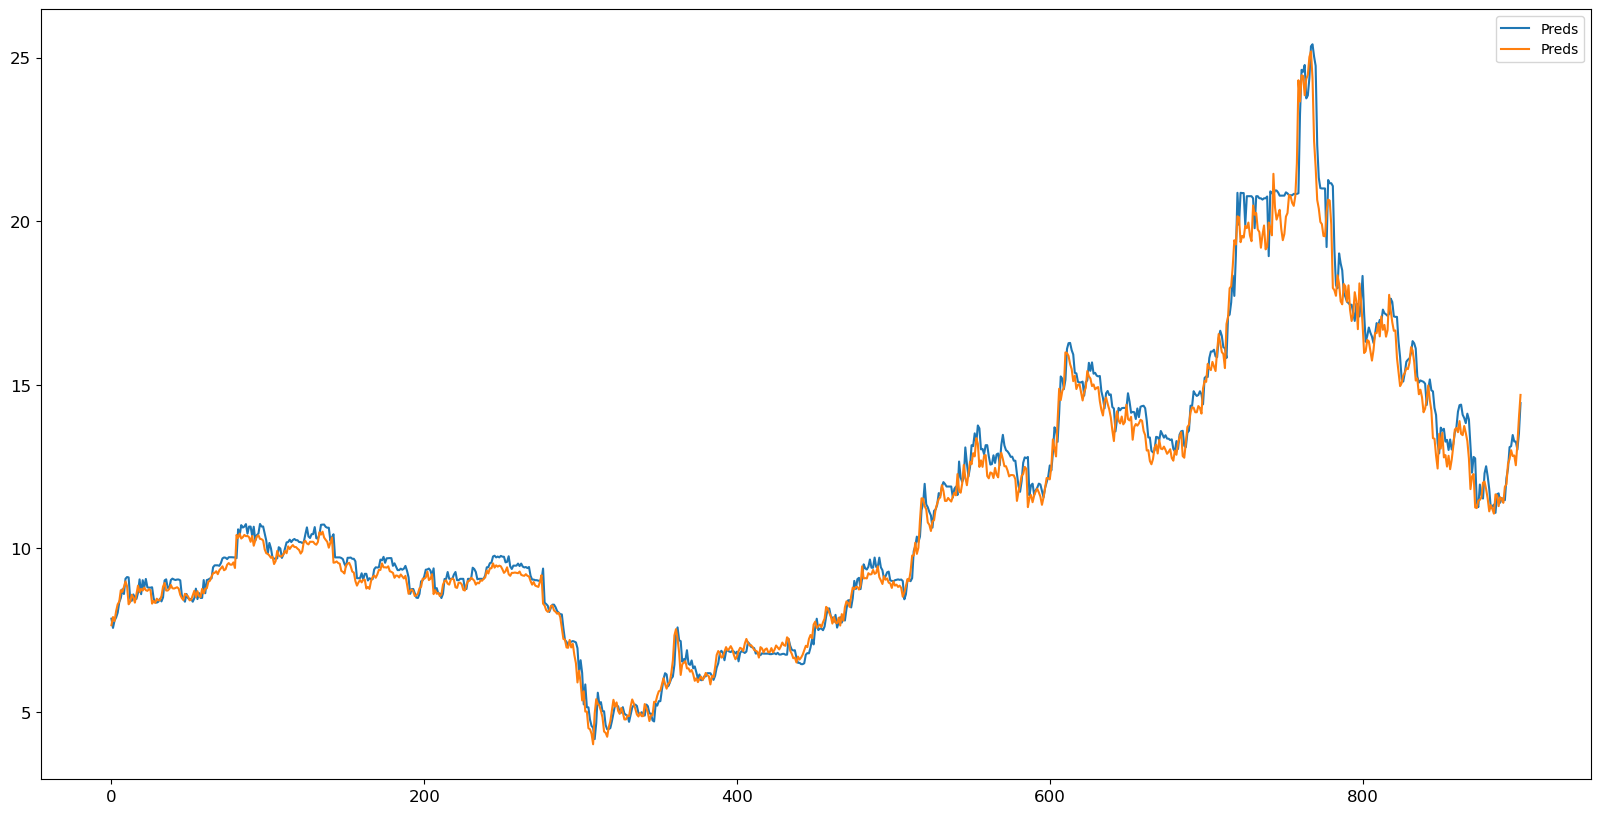

In [23]:
plt.figure(figsize=(20,10))
plt.plot(y_predicted, label="Preds")
plt.plot(y_test, label="Preds")
plt.legend()
plt.show()

### Prediction using Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(x_train, y_train)
lin_reg.score(x_train, y_train)

0.9970419150647106

In [25]:
lin_reg_preds = lin_reg.predict(x_test)

lin_rmse = math.sqrt(mean_squared_error(y_test, lin_reg_preds))
print("RMSE : ", lin_rmse)
lin_mae = mean_absolute_error(y_test, lin_reg_preds)
print("MAE : ", lin_mae)
lin_mape = mean_absolute_percentage_error(y_test, lin_reg_preds)
print("MAPE : ", lin_mape)

RMSE :  0.337327800481679
MAE :  0.2220845567613351
MAPE :  0.020153186733040205


#### Linear regression training prediction vs original price movement

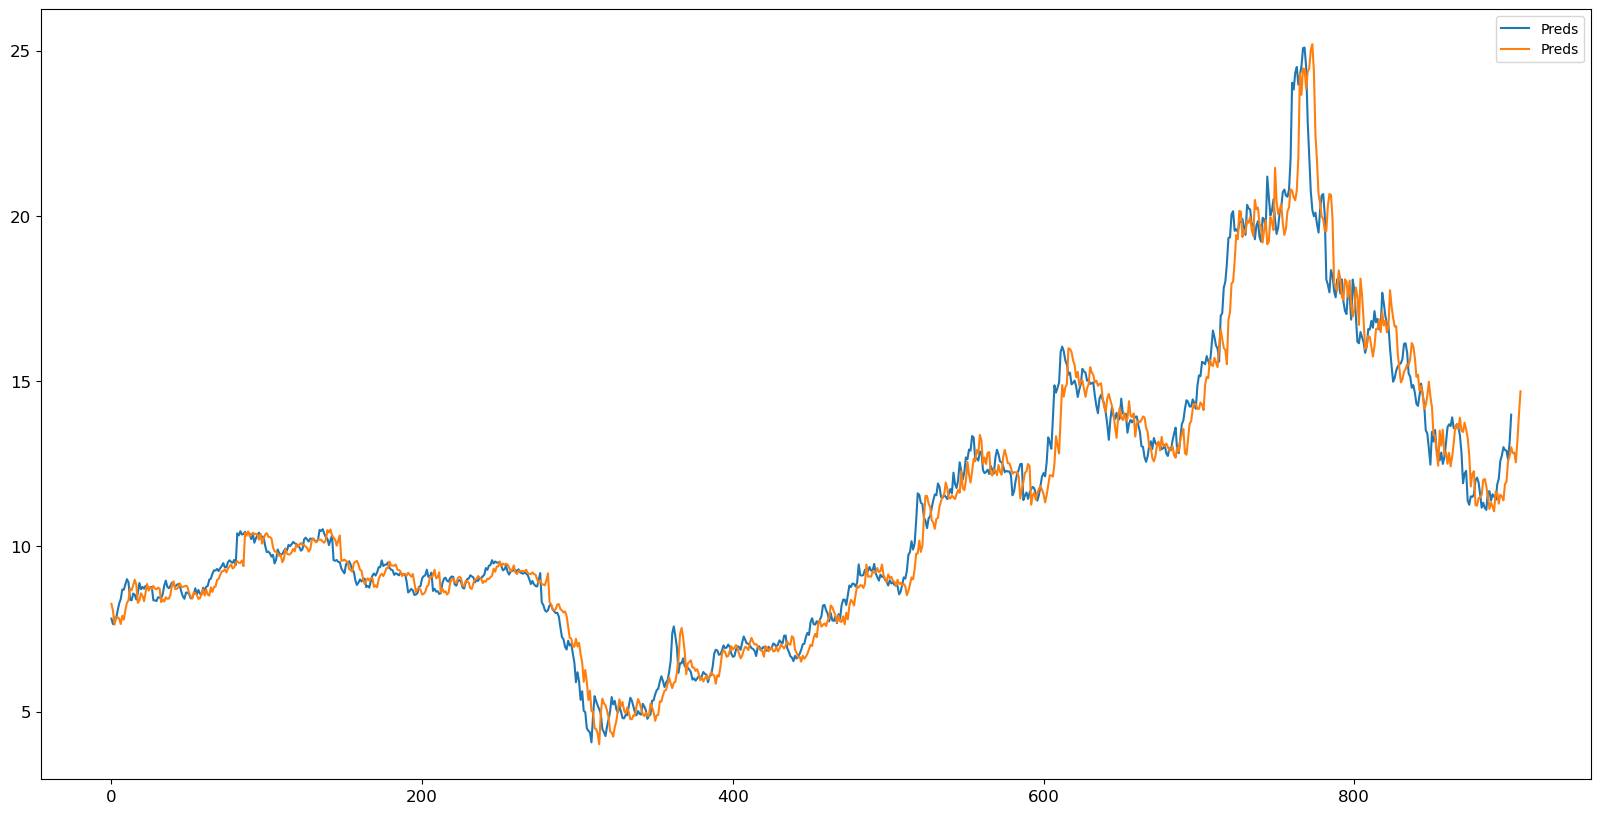

In [54]:
plt.figure(figsize=(20,10))
plt.plot(lin_reg_preds, label="Preds")
plt.plot(y_test, label="Preds")
plt.legend()
plt.show()

### Predicting 5 days into the future

In [26]:
shift_range = [x+1 for x in range(5)]

for shift in tqdm_notebook(shift_range):
    train_shift = ford_stock_indicators[merging_keys + lag_cols].copy()
    
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(ford_stock_indicators, train_shift, on=merging_keys, how='left')
    
    
del train_shift

# Remove the first 40 rows which contain NaNs. Combination of NaNs due to shifting and moving average indicators
df_12 = df[40:]
    


/var/folders/lr/pq20k0jn2_3b2d62clqcps300000gn/T/ipykernel_71718/2077051794.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm_notebook(shift_range):


  0%|          | 0/5 [00:00<?, ?it/s]

In [27]:
features_12 = df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA5',
       'MA10', 'MA20', 'ADX', 'ADXR', 'MACD', 'RSI', 'BBANDS_U', 'BBANDS_M',
       'BBANDS_L', 'AD', 'ATR', 'HT_DC', 'order_day'], axis = 1).copy()
target_12 = df[['Close']].copy()

np_features = np.array(features_12)
np_target = np.array(target_12)

x_train, x_val, x_test = data_splitter(np_features)
y_train, y_val, y_test = data_splitter(np_target)

x_train_scaled, y_train_scaled = dataset_transformer(x_train, y_train)
x_val_scaled, y_val_scaled  = dataset_transformer(x_val, y_val)
x_test_scaled, y_test_scaled  = dataset_transformer(x_test, y_test)




#### XGBoost 5 day prediction

In [28]:
predicted_5_days = model_2.predict(X=x_test)

In [29]:
rmse = math.sqrt(mean_squared_error(y_test, predicted_5_days))
print("5_day_RMSE : ", rmse)
mae = mean_absolute_error(y_test, predicted_5_days)
print("5_day_MAE : ", mae)
mape = mean_absolute_percentage_error(y_test, predicted_5_days)
print("5_day_MAPE : ", mape)

5_day_RMSE :  0.8352646191686306
5_day_MAE :  0.5710407947128565
5_day_MAPE :  0.05226575506179479


#### Linear Regression 5 day prediction

In [30]:
predicted_5_days = lin_reg.predict(x_test)

In [31]:


rmse = math.sqrt(mean_squared_error(y_test, predicted_5_days))
print("5_day_RMSE : ", rmse)
mae = mean_absolute_error(y_test, predicted_5_days)
print("5_day_MAE : ", mae)
mape = mean_absolute_percentage_error(y_test, predicted_5_days)
print("5_day_MAPE : ", mape)

5_day_RMSE :  0.7511419573015398
5_day_MAE :  0.49250855382420616
5_day_MAPE :  0.04509456070169361


## Predicting 10 days into the future

In [32]:
shift_range = [x+1 for x in range(10)]

for shift in tqdm_notebook(shift_range):
    train_shift = ford_stock_indicators[merging_keys + lag_cols].copy()
    
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(ford_stock_indicators, train_shift, on=merging_keys, how='left')
    
    
del train_shift

# Remove the first 40 rows which contain NaNs. Combination of NaNs due to shifting and moving average indicators
df_12 = df[40:]

/var/folders/lr/pq20k0jn2_3b2d62clqcps300000gn/T/ipykernel_71718/537944383.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm_notebook(shift_range):


  0%|          | 0/10 [00:00<?, ?it/s]

In [33]:
features_10 = df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA5',
       'MA10', 'MA20', 'ADX', 'ADXR', 'MACD', 'RSI', 'BBANDS_U', 'BBANDS_M',
       'BBANDS_L', 'AD', 'ATR', 'HT_DC', 'order_day'], axis = 1).copy()
target_10 = df[['Close']].copy()

np_features = np.array(features_10)
np_target = np.array(target_10)

x_train, x_val, x_test = data_splitter(np_features)
y_train, y_val, y_test = data_splitter(np_target)

x_train_scaled, y_train_scaled = dataset_transformer(x_train, y_train)
x_val_scaled, y_val_scaled  = dataset_transformer(x_val, y_val)
x_test_scaled, y_test_scaled  = dataset_transformer(x_test, y_test)


In [34]:
predicted_10_days = model_2.predict(X=x_test)

rmse = math.sqrt(mean_squared_error(y_test, predicted_10_days))
print("10_day_RMSE : ", rmse)
mae = mean_absolute_error(y_test, predicted_10_days)
print("10_day_MAE : ", mae)
mape = mean_absolute_percentage_error(y_test, predicted_10_days)
print("10_day_MAPE : ", mape)

10_day_RMSE :  1.1461311414639168
10_day_MAE :  0.7874241122065136
10_day_MAPE :  0.07034782166437784


### Linear regression 10 day prediction

In [35]:
predicted_10_days = lin_reg.predict(x_test)

rmse = math.sqrt(mean_squared_error(y_test, predicted_10_days))
print("10_day_RMSE : ", rmse)
mae = mean_absolute_error(y_test, predicted_10_days)
print("10_day_MAE : ", mae)
mape = mean_absolute_percentage_error(y_test, predicted_10_days)
print("10_day_MAPE : ", mape)

10_day_RMSE :  1.0837104677072351
10_day_MAE :  0.7140726983913679
10_day_MAPE :  0.06330482235422284


## Predicting 15 days into the future

In [40]:
shift_range = [x+1 for x in range(15)]

for shift in tqdm_notebook(shift_range):
    train_shift = ford_stock_indicators[merging_keys + lag_cols].copy()
    
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(ford_stock_indicators, train_shift, on=merging_keys, how='left')
    
    
del train_shift

# Remove the first 40 rows which contain NaNs. Combination of NaNs due to shifting and moving average indicators
df_12 = df[40:]

/var/folders/lr/pq20k0jn2_3b2d62clqcps300000gn/T/ipykernel_71718/2194506651.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm_notebook(shift_range):


  0%|          | 0/15 [00:00<?, ?it/s]

In [41]:
features_15 = df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA5',
       'MA10', 'MA20', 'ADX', 'ADXR', 'MACD', 'RSI', 'BBANDS_U', 'BBANDS_M',
       'BBANDS_L', 'AD', 'ATR', 'HT_DC', 'order_day'], axis = 1).copy()
target_15 = df[['Close']].copy()

np_features = np.array(features_15)
np_target = np.array(target_15)

x_train, x_val, x_test = data_splitter(np_features)
y_train, y_val, y_test = data_splitter(np_target)

x_train_scaled, y_train_scaled = dataset_transformer(x_train, y_train)
x_val_scaled, y_val_scaled  = dataset_transformer(x_val, y_val)
x_test_scaled, y_test_scaled  = dataset_transformer(x_test, y_test)

#### XGBoost 15 day prediction

In [42]:
predicted_15_days = model_2.predict(X=x_test)

rmse = math.sqrt(mean_squared_error(y_test, predicted_15_days))
print("15_day_RMSE : ", rmse)
mae = mean_absolute_error(y_test, predicted_15_days)
print("15_day_MAE : ", mae)
mape = mean_absolute_percentage_error(y_test, predicted_15_days)
print("15_day_MAPE : ", mape)

15_day_RMSE :  1.3985168967001433
15_day_MAE :  0.9805797674582393
15_day_MAPE :  0.08871870038577659


#### Linear regression 15 day prediction

In [43]:
predicted_15_days = lin_reg.predict(x_test)

rmse = math.sqrt(mean_squared_error(y_test, predicted_15_days))
print("15_day_RMSE : ", rmse)
mae = mean_absolute_error(y_test, predicted_15_days)
print("15_day_MAE : ", mae)
mape = mean_absolute_percentage_error(y_test, predicted_15_days)
print("15_day_MAPE : ", mape)

15_day_RMSE :  1.3524737167739618
15_day_MAE :  0.9106426388012854
15_day_MAPE :  0.08159549532510657
